# Part I: Loading Libraries

In [1]:
#Data visualization and analysis 
import pandas as pd
import matplotlib.pyplot as plt

#Data cleaning
import re
import string

#Data engineering and math
import numpy as np

import nltk

#Tokenizing
import spacy
nlp = spacy.load("en_core_web_sm")

#POS-Tagging
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.corpus import brown
nltk.download('brown')

#Lemmatizing
from nltk.stem import WordNetLemmatizer

#Vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer

#Handling sparse matrix during vectorization
from scipy.sparse import csr_matrix

#Data Splitting
from sklearn.model_selection import train_test_split

#NBSVM model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

#Model Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#NBSVM fine tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#Padding and embeddings - bi-LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#bi-LSTM model - Keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Dropout, LSTM, Flatten
from tensorflow.keras.regularizers import l2

#Model saving
import joblib

#text preprocessing - LLM
from gensim.utils import simple_preprocess
from sklearn.preprocessing import LabelEncoder

#Fine-tune LLM - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

#Fine-tune LLM - HuggingFace
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AlbertForSequenceClassification, AlbertConfig

#Create custom dataset
from torch.utils.data import Dataset

/home/x-tdo3/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/x-tdo3/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/apps/anvil/external/apps/jupyter/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to /home/x-tdo3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /home/x-tdo3/nltk_data...
[nltk_data]   Package brown is already up-to-date!
2024-07-24 

# Part II: Data Engineering: combining and cleaning different datasets

**Dataset 1: GOSU.ai dota 2 chat dataset**

In [3]:
#Load the dataset
path = 'tagged-data.csv'
dota2_df = pd.read_csv(path)
dota2_df.head(5)

,Unnamed: 0,match,time,slot,text,target
0,2,2,2263.90490,4,COMMEND ME TY,0
1,7,6,242.54080,8,sorry nex,0
2,11,6,2279.16280,2,what is the best soup?,0
3,18,9,1011.11982,4,man that silence on axe,0
4,21,9,1769.30452,3,not coming into play,0


In [4]:
#By convention, 0 represents negative, and 1 represents positive
#In this case, mildly negative will be transformed to negative
dota2_df['target'] = dota2_df['target'].replace({1: 0, 2: 0, 0: 1})

In [5]:
#Check for any null data
dota2_df.isnull().any()

Unnamed: 0    False
match         False
time          False
slot          False
text          False
target        False
dtype: bool

In [13]:
#Apply clean functions and drop unused parts of the data frame
dota2_df['text_cleaned'] = dota2_df['text'].apply(clean).str.lower()
columns_to_drop = ['match', 'time', 'slot']
dota2_df = dota2_df.drop(columns = columns_to_drop)

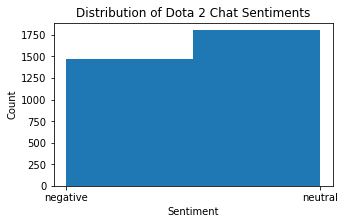

In [14]:
#Plot the distribution of negative and positive values

plt.figure(figsize = (5, 3))
plt.hist(dota2_df['target'], bins = 2)

plt.title('Distribution of Dota 2 Chat Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.xticks([0, 1], ['negative', 'neutral'])

plt.show()

In [15]:
#View the transformed data
dota2_df

,Unnamed: 0,text,target,text_cleaned
0,2,COMMEND ME TY,1,commend me ty
1,7,sorry nex,1,sorry nex
2,11,what is the best soup?,1,what is the best soup
3,18,man that silence on axe,1,man that silence on axe
4,21,not coming into play,1,not coming into play
...,...,...,...,...
3262,9986,"wt?f?asfU JGOFIDLK,YH",0,wtfasfu jgofidlkyh
3263,10003,you must really suck,0,you must really suck
3264,10007,YOU HAVE IDIOT PLAYER,0,you have idiot player
3265,10010,SUPER IDIOT,0,super idiot


In [16]:
#The number of negative vs. positive
print(f"negative: {dota2_df['target'].value_counts().get(0, 0)}")
print(f"positive: {dota2_df['target'].value_counts().get(1, 0)}")

negative: 1467
positive: 1800


**Loading Dataset 2: Social Media Comments on Gaming**

In [17]:
#Load and view the dataset
path = 'cleaned_comments.csv'
sm_df = pd.read_csv(path)
sm_df.head(5)

,Unnamed: 0,comment,sentiment
0,0,dont think like game havent even played minute...,negative
1,1,leave farm smaller creature either wait help k...,negative
2,2,nothing beat feeling get see fall love like ye...,positive
3,3,also theyre made paper edit tried make gif fai...,negative
4,4,haha exactly brother tried get wow run raid ge...,positive


In [18]:
#Check for nullity
sm_df.isnull().any()

Unnamed: 0    False
comment        True
sentiment     False
dtype: bool

In [19]:
#Drop null rows
sm_df.dropna(subset = 'comment', inplace = True)

In [20]:
#Drop comments with more than 150 characters, delete the extra column after usage

sm_df['comment'] = sm_df['comment'].astype(str)

sm_df['text_length'] = sm_df['comment'].apply(len)
sm_df = sm_df[sm_df['text_length'] <= 150]
sm_df.drop(columns = ['text_length'], inplace = True)

In [43]:
#One-hot encode the target and clean the data
sm_df['sentiment'] = sm_df['sentiment'].replace({'negative': 0, 'neutral': 1, 'positive': 1})
sm_df['text_cleaned'] = sm_df['comment'].apply(clean).str.lower()

In [44]:
#View the cleaned data frame
sm_df

,Unnamed: 0,comment,sentiment,text_cleaned
0,0,dont think like game havent even played minute...,0,dont think like game havent even played minute...
1,1,leave farm smaller creature either wait help k...,0,leave farm smaller creature either wait help k...
2,2,nothing beat feeling get see fall love like ye...,1,nothing beat feeling get see fall love like ye...
3,3,also theyre made paper edit tried make gif fai...,0,also theyre made paper edit tried make gif fai...
4,4,haha exactly brother tried get wow run raid ge...,1,haha exactly brother tried get wow run raid ge...
...,...,...,...,...
21816,23184,dont angry,1,dont angry
21817,23185,human free developed relationship esteemed fellow,1,human free developed relationship esteemed fellow
21818,23186,dont call shot around mister,1,dont call shot around mister
21819,23187,sorry going edit beauty mark face,1,sorry going edit beauty mark face


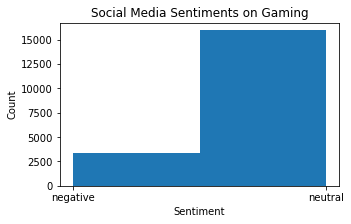

In [45]:
#Plot the distribution of sentiments
#Since there are siginifcant differences, we need to add a third dataset

plt.figure(figsize = (5, 3))
plt.hist(sm_df['sentiment'], bins = 2)

plt.title('Social Media Sentiments on Gaming')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.xticks([0, 1], ['negative', 'neutral'])

plt.show()

In [46]:
#The difference is roughly 13,000
print(f"negative: {sm_df['sentiment'].value_counts().get(0, 0)}")
print(f"positive: {sm_df['sentiment'].value_counts().get(1, 0)}")

negative: 3375
positive: 15934


**Dataset 3: League of Legends Tribunal Chat Log**

In [26]:
#Load and view the dataset
#Note that this dataset only contains negative sentiments
path = 'chatlogs.csv'
lol_df = pd.read_csv(path)
lol_df.head(5)

,Unnamed: 0,message,association_to_offender,time,case_total_reports,allied_report_count,enemy_report_count,most_common_report_reason,chatlog_id,champion_name
0,0,gold 2 zed,enemy,00:00:21,8,0,2,Negative Attitude,1,Udyr
1,1,IIII,enemy,00:00:27,8,0,2,Negative Attitude,1,Riven
2,2,nice premade lie :o,enemy,00:00:27,8,0,2,Negative Attitude,1,Udyr
3,3,ISI,enemy,00:00:28,8,0,2,Negative Attitude,1,Riven
4,4,smiteless pls,enemy,00:00:43,8,0,2,Negative Attitude,1,Udyr


In [27]:
#Check for nullity
lol_df.isnull().any()

Unnamed: 0                   False
message                       True
association_to_offender       True
time                         False
case_total_reports           False
allied_report_count          False
enemy_report_count           False
most_common_report_reason    False
chatlog_id                   False
champion_name                 True
dtype: bool

In [28]:
#Drop null rows
lol_df.dropna(subset = 'message', inplace = True)

In [29]:
#Since there are roughly 1,000,000 records on this dataset, we only take a subset of 15,000 in this part of the project
#The remaining data will be saved for the second part
lol_sample_df = lol_df.sample(n = 15000, random_state = 42)
lol_remaining_df = lol_df.drop(lol_sample_df.index)

In [30]:
#Drop the unused columns of the splitted data frame
columns_to_drop = ['association_to_offender', 'time', 'case_total_reports', 'allied_report_count', 'enemy_report_count', 'most_common_report_reason', 'chatlog_id', 'champion_name']
lol_sample_df = lol_sample_df.drop(columns = columns_to_drop)

#Create a new column target will all values initiated to 0
#Since all sentiments here are negative
lol_sample_df['target'] = 0

In [39]:
#Clean the texts
lol_sample_df['text_cleaned'] = lol_sample_df['message'].apply(clean).str.lower()

In [40]:
#View the cleaned data frame
lol_sample_df

,Unnamed: 0,message,target,text_cleaned
511078,511078,u are the most moron player i have ever see,0,u are the most moron player i have ever see
127527,127527,so u go and suicide,0,so u go and suicide
1469114,1469114,graves,0,graves
1052704,1052704,do blue,0,do blue
1357793,1357793,no life and no mana ? open ur eyes ;),0,no life and no mana open ur eyes
...,...,...,...,...
1063359,1063359,wtf ?,0,wtf
639004,639004,he is weird,0,he is weird
995203,995203,ward baron maybe?,0,ward baron maybe
1032569,1032569,ashe... don't be so proud of urself.... u're n...,0,ashe dont be so proud of urself ure not even good


**Saving Remaining LOL Dataset for Future Usage**

In [ ]:
#Download the remaining data frame

lol_remaining_df.to_csv('lol_report_chat.csv', index=False)

from google.colab import files
files.download('lol_report_chat.csv')

**Combining Data from the Three Datasets**

In [36]:
#Combine the target column
combined_sentiment = pd.concat([lol_sample_df['target'], sm_df['sentiment'], dota2_df['target']], ignore_index = True)

combined_sentiment.head(3)

0    0
1    0
2    0
dtype: int64

In [47]:
#Combine the text column, preserve the order of the previous concatenation
combined_text = pd.concat([lol_sample_df['text_cleaned'], sm_df['text_cleaned'], dota2_df['text_cleaned']], ignore_index = True)

combined_text.head(3)

0    u are the most moron player i have ever see
1                            so u go and suicide
2                                         graves
Name: text_cleaned, dtype: object

In [48]:
#Create a new data frame of the combined data

data = {
    'text': combined_text,
    'target': combined_sentiment
}

df = pd.DataFrame(data)

In [49]:
#View the data frame
df

,text,target
0,u are the most moron player i have ever see,0
1,so u go and suicide,0
2,graves,0
3,do blue,0
4,no life and no mana open ur eyes,0
...,...,...
37571,wtfasfu jgofidlkyh,0
37572,you must really suck,0
37573,you have idiot player,0
37574,super idiot,0


**Downloading DataFrame for Further Usage**

In [ ]:
#Download the data frame into csv format

df.to_csv('chat_classification.csv', index=False)

from google.colab import files
files.download('chat_classification.csv')

# Part III: External Functions

**Text Cleaning**

In [8]:
def remove_url(text):
  '''
  Params:
  text: a string
  Returns:
  the same string with possible urls removed
  '''
  return re.sub(r"https?://\S+|www\.\S+", "", text)


In [9]:
def remove_html(text):
  '''
  Params:
  text: a string
  Returns:
  the same string with possible htmls removed
  '''
  html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    
  return re.sub(html, "", text)

In [10]:
def remove_non_ascii(text):
  '''
  Params:
  text: a string
  Returns:
  the same string with possible htmls removed
  '''
  return re.sub(r'[^\x00-\x7f]',r'', text)

In [11]:
def remove_special_characters(text):
    """
    Params:
    text: a string
    Returns:
    the same string with possible special special characters, including symbols, emojis, and other graphic characters removed
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [12]:
def remove_punctuations(text):
  '''
  Params:
  text: a string
  Returns:
  the same string with punctuations removed
  '''
  return text.translate(str.maketrans('', '', string.punctuation))

In [13]:
def clean(text):
  '''
  Params:
  text: a string
  Returns:
  a clean version of that text
  '''
  text = remove_url(text)
  text = remove_html(text)
  text = remove_special_characters(text)
  text = remove_non_ascii(text)
  text = remove_punctuations(text)

  return text

**Text Preprocessing**

In [14]:
def spacy_tokenize(text):
  '''
  tokenize a single text object using spaCy
  '''
  doc = nlp(text)

  return [token.text for token in doc]

In [15]:
#Create a map for tagging
wordnet_map = {
  "N":wordnet.NOUN,
  "V":wordnet.VERB,
  "J":wordnet.ADJ,
  "R":wordnet.ADV
}

train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
  """
  apply pos_taging with wordnet format
  """
  pos_tagged_text = t2.tag(text)
  pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text]

  return pos_tagged_text

In [16]:
def nltk_lemmatize(text):
  """
  lemmatize the tokenized words using nltk
  """

  lemmatizer = WordNetLemmatizer()
  lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]

  return lemma

In [17]:
def gensim_tokenize(text):
  '''
  tokenize using gensim tokenizer
  '''
  return simple_preprocess(text)

# Part IV: Preprocessing Data

In [51]:
#Open and view the file
path = 'chat_classification.csv'
df1 = pd.read_csv(path)

df1.head()

,text,target
0,u are the most moron player i have ever see,0
1,so u go and suicide,0
2,graves,0
3,do blue,0
4,no life and no mana open ur eyes,0


In [52]:
#Since there are a few empty rows, omit them
df1 = df1[df1['text'].notna() & (df1['text'].str.strip() != '')]
df1['text'].isnull().any()

False

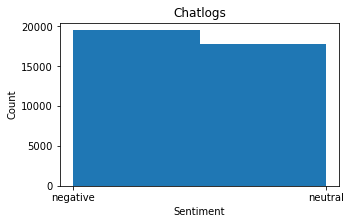

In [53]:
#Plot the distribution of sentiments

plt.figure(figsize = (5, 3))
plt.hist(df1['target'], bins = 2)

plt.title('Chatlogs')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.xticks([0, 1], ['negative', 'neutral'])

plt.show()

**Tokenization**

In [58]:
#Tokenize the text using spaCy library
df1['spacy_tokenized'] = df1['text'].apply(spacy_tokenize)
df1.head()

,text,target,spacy_tokenized
0,u are the most moron player i have ever see,0,"[u, are, the, most, moron, player, i, have, ev..."
1,so u go and suicide,0,"[so, u, go, and, suicide]"
2,graves,0,[graves]
3,do blue,0,"[do, blue]"
4,no life and no mana open ur eyes,0,"[no, life, and, no, mana, , open, ur, eyes]"


**POS-Tagging**

In [59]:
#POS-Tagging on tokenized text
#It is experimented that lemmatization/stemming works slightly (if not much) better with POS-Tagging
df1['postag_wnet'] = df1['spacy_tokenized'].apply(lambda x: pos_tag_wordnet(x))

df1

,text,target,spacy_tokenized,postag_wnet
0,u are the most moron player i have ever see,0,"[u, are, the, most, moron, player, i, have, ev...","[(u, n), (are, n), (the, n), (most, n), (moron..."
1,so u go and suicide,0,"[so, u, go, and, suicide]","[(so, n), (u, n), (go, v), (and, n), (suicide,..."
2,graves,0,[graves],"[(graves, n)]"
3,do blue,0,"[do, blue]","[(do, n), (blue, a)]"
4,no life and no mana open ur eyes,0,"[no, life, and, no, mana, , open, ur, eyes]","[(no, n), (life, n), (and, n), (no, n), (mana,..."
...,...,...,...,...
37571,wtfasfu jgofidlkyh,0,"[wtfasfu, jgofidlkyh]","[(wtfasfu, n), (jgofidlkyh, n)]"
37572,you must really suck,0,"[you, must, really, suck]","[(you, n), (must, n), (really, r), (suck, n)]"
37573,you have idiot player,0,"[you, have, idiot, player]","[(you, n), (have, n), (idiot, n), (player, n)]"
37574,super idiot,0,"[super, idiot]","[(super, a), (idiot, n)]"


**Lemmatization**

In [60]:
#Lemmatize text on the POS-Tagged data
df1['nltk_lemmatized_w_pos'] = df1['postag_wnet'].apply(lambda x: nltk_lemmatize(x))

#Remove tokenization, since we will re-tokenize by passing a tokenizer into the tfidf-vectorizer
df1['nltk_lemmatized'] = [' '.join(map(str, l)) for l in df1['nltk_lemmatized_w_pos']]

df1.head(5)

,text,target,spacy_tokenized,postag_wnet,nltk_lemmatized_w_pos,nltk_lemmatized
0,u are the most moron player i have ever see,0,"[u, are, the, most, moron, player, i, have, ev...","[(u, n), (are, n), (the, n), (most, n), (moron...","[u, are, the, most, moron, player, i, have, ev...",u are the most moron player i have ever see
1,so u go and suicide,0,"[so, u, go, and, suicide]","[(so, n), (u, n), (go, v), (and, n), (suicide,...","[so, u, go, and, suicide]",so u go and suicide
2,graves,0,[graves],"[(graves, n)]",[graf],graf
3,do blue,0,"[do, blue]","[(do, n), (blue, a)]","[do, blue]",do blue
4,no life and no mana open ur eyes,0,"[no, life, and, no, mana, , open, ur, eyes]","[(no, n), (life, n), (and, n), (no, n), (mana,...","[no, life, and, no, mana, , open, ur, eye]",no life and no mana open ur eye


# Part IV: Naive Bayes - Support Vector Machine (NB-SVM) Model

**Vectorization**

In [61]:
#Define variables
corpus = df1["nltk_lemmatized"].tolist()
labels = df1['target']
corpus[:5]

['u are the most moron player i have ever see',
 'so u go and suicide',
 'graf',
 'do blue',
 'no life and no mana   open ur eye']

In [62]:
#Split data into train, test, and cross validation set
#The ratio is 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(corpus, labels, test_size = 0.3, random_state = 2802)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 2802)

In [63]:
#Create a vectorization object
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), tokenizer = spacy_tokenize,
               min_df = 5, max_df = 0.85, strip_accents='unicode', use_idf = 1,
               smooth_idf = 1, sublinear_tf = 1)

#We fit the vectorizer onto the training set and vectorize it
X_train_vec = tfidf_vec.fit_transform(X_train)

#We do not want to fit the vectorizer again, so simply vectorize the remaining (lesser) sets is more ideal
X_test_vec = tfidf_vec.transform(X_test)
X_val_vec = tfidf_vec.transform(X_val)

**Train the model**

In [93]:
def nb_features(X, y):
  '''
  Apply a Naive-Bayes feature scaling transformation on the input data
  '''
  def pr(y_i, y):
    '''
    Calculate the ratio of each feature presenting in its respective class (0 or 1)
    '''
    p = X[y == y_i].sum(0)
    return (p + 1) / ((y == y_i).sum() + 1)

  y = y.values
  r = np.log(pr(1, y) / pr(0, y))
  x_nb = X.multiply(r)

  return x_nb

In [66]:
#Transform the input using NB scaling

X_train_nb = nb_features(X_train_vec, y_train)

X_test_nb = nb_features(X_test_vec, y_test)
X_val_nb = nb_features(X_val_vec, y_val)

In [67]:
#Define the model

svm_model = SVC(C = 1, gamma = 'auto', kernel = 'linear', class_weight = 'balanced', probability = True)

#Fit the model

svm_model.fit(X_train_nb, y_train)

SVC(C=1, class_weight='balanced', gamma='auto', kernel='linear',
    probability=True)

**Model Evaluation**

In [ ]:
#Randomized Search algorithm

param_distributions = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(svm_model, param_distributions, n_iter = 50, scoring = 'f1', cv = 4, random_state = 2802)

random_search.fit(X_train_nb, y_train)

print("Best parameters found: ", random_search.best_params_)

In [ ]:
#Grid Search Algorithm

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Adjusted C values
    'kernel': ['linear', 'rbf', 'poly'],  # Added 'poly' for polynomial kernel
    'degree': [2, 3, 4],  # Degrees for 'poly' kernel
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svm_model, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_nb, y_train)

print("Best parameters found: ", grid_search.best_params_)

**Note:** To avoid running again these time consuming algorithm, the reslts are shown as follows: 
- C = 1, Gamma = 'auto', kernel = 'linear

In [69]:
#Calculate evaluation metrics

y_pred = svm_model.predict(X_test_nb)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
f_score = f1_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"F1 Score: {f_score:.5f}")
print(f"Recall: {recall:.5f}")

Accuracy: 0.85522
Precision: 0.87318
F1 Score: 0.84256
Recall: 0.81401


AUC-ROC: 0.9216752265472145


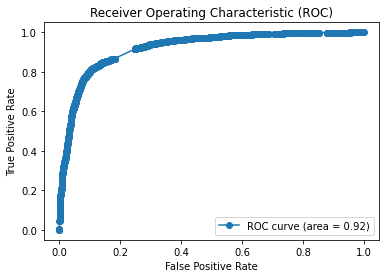

In [70]:
# Predict probabilities for AUC-ROC
y_pred_prob = svm_model.predict_proba(X_test_nb)[:, 1]

# Compute AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC-ROC: {auc_roc}')

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, marker='o', label='ROC curve (area = %0.2f)' % auc_roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

Confusion Matrix:
[[2611  314]
 [ 494 2162]]


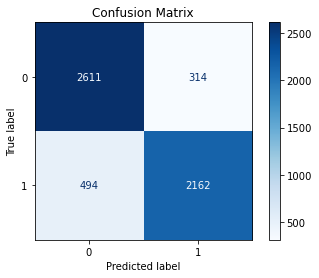

In [71]:
# Predict class labels for confusion matrix
y_pred = svm_model.predict(X_test_nb)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

**Note:** (chronologically ordered)  
After running randomized search and further tuning, a decision had been called to:  
- Decrease regularization parameter C from 10 to 0.1, thus creating a simpler decision boundary and reduce overfitting, making a better generalization, as shown in reducing precision.
- Changing the kernel type to rbf slightly decrease all three metrics
- Changing the kernel coefficient gamma from 'scale' to 'auto' does not change our metrics
- Linear kernel is the best type of kernel so far, as changing to polynomial and sigmoid reduce significantly the results
- Removing class_weights param slightly decrease performance
- Increasing C from 0.1 to 1 has cause precision to increase (as expected), slightly reduce recall, while maintaing f1 score
- Higher value of C (100 in this case) leading to longer convergence, and of course, decrease recall dramatically

**Save the model**

In [ ]:
# Save the model to a file

joblib.dump(svm_model, 'tri282_nbsvm_model_sentiment_classification')

# Part V: Bi-directional LSTM

In [72]:
df1['nltk_lemmatized'].head(5)

0    u are the most moron player i have ever see
1                            so u go and suicide
2                                           graf
3                                        do blue
4              no life and no mana   open ur eye
Name: nltk_lemmatized, dtype: object

In [73]:
#Split data into train, test, and cross validation set
#The ratio is 70/15/15

labels = df1['target']

X_train, X_temp, y_train, y_temp = train_test_split(df1['nltk_lemmatized_w_pos'].tolist(), labels, test_size = 0.3, random_state = 2802)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 2802)

In [74]:
#Flatten tokenized words from a df to a list

train_tokens = [token for tokens in X_train for token in tokens]

In [75]:
# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # Fit on training data

# Convert texts to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [76]:
# Calculate text lengths from the original sequences
text_lengths = [len(seq) for seq in X_train_sequences]

In [77]:
#Define the maximum number of words and padding length
max_words = 32000
max_length = 150

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen = max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_length, padding='post')

In [78]:
#Get the word index dictionary
word_index = tokenizer.word_index

#Embedding size
emb_dim = 150

#Determine the vocabulary size
vocab_size = len(word_index) + 1  # Adding 1 for zero-padding

**Train the model (Tensorflow)**

In [79]:
bi_lstm_tf_model = Sequential([
    #embedding layer, adding l2 regularization param to prevent overfitting
    Embedding(input_dim = vocab_size, output_dim = emb_dim, embeddings_regularizer = l2(0.01)),
    
    #Two bidirectional layer, the second one does not need return_sequences
    #Since intermediate layers need to return the full sequence to be further processed by next layer(s)
    #Dropout params set a fraction (10% here) of neurons to 0, prevent overfitting, which is common in NN
    Bidirectional(LSTM(64, dropout = 0.1, recurrent_dropout = 0.1, return_sequences = True)),
    Bidirectional(LSTM(64, dropout = 0.1, recurrent_dropout = 0.1)),
    
    #Add a dense layer to transform inputs from LSTM 
    Dense(64, activation = 'relu', kernel_regularizer = l2(0.01)),
    
    #A separate dropout layer to prevent overfitting
    Dropout(0.2),
    
    #Final layer for binary classification
    Dense(1, activation = 'sigmoid')
])

bi_lstm_tf_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    
    #AdamW is shown to have slightly better performance than Adam
    optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001),
    
    metrics = ['accuracy']
)

early_stopping = EarlyStopping(
    monitor = 'val_loss',

    #reduce patience from 15 -> 5 since model easily overfits in the first 3-5 epochs
    patience = 5,

    restore_best_weights = True
)

bi_lstm_tf_model.fit(X_train_padded, y_train.values, epochs = 15, batch_size = 32, validation_data = (X_val_padded, y_val.values), callbacks = [early_stopping])

Epoch 1/15
814/814 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.7062 - loss: 2.1926 - val_accuracy: 0.7975 - val_loss: 0.6021
Epoch 2/15
814/814 ━━━━━━━━━━━━━━━━━━━━ 72s 89ms/step - accuracy: 0.8051 - loss: 0.5881 - val_accuracy: 0.8125 - val_loss: 0.5729
Epoch 3/15
814/814 ━━━━━━━━━━━━━━━━━━━━ 70s 87ms/step - accuracy: 0.8275 - loss: 0.5469 - val_accuracy: 0.8185 - val_loss: 0.5529
Epoch 4/15
814/814 ━━━━━━━━━━━━━━━━━━━━ 70s 85ms/step - accuracy: 0.8435 - loss: 0.5147 - val_accuracy: 0.8272 - val_loss: 0.5473
Epoch 5/15
814/814 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.8567 - loss: 0.4905 - val_accuracy: 0.8287 - val_loss: 0.5424
Epoch 6/15
814/814 ━━━━━━━━━━━━━━━━━━━━ 76s 94ms/step - accuracy: 0.8614 - loss: 0.4801 - val_accuracy: 0.8337 - val_loss: 0.5473
Epoch 7/15
814/814 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - accuracy: 0.8691 - loss: 0.4665 - val_accuracy: 0.8292 - val_loss: 0.5476
Epoch 8/15
814/814 ━━━━━━━━━━━━━━━━━━━━ 71s 87ms/step - accuracy: 0.8687 - loss: 0.4613 - 

**Note:**
- Changing the last layer from linear to sigmoid (removing logits) helped model less overfits and slightly increase validation accuracy
- Adding regularization param in the embedding and the dense layer, and increasing dropout slightly decrease performance
- Remove regularization, decrease batch size, reduce the number of neurons in the dense layer slightly improve accuracy and mitigate overfitting
- Reduce batch size even more increase accuracy
- Further increase number of neurons per layer does not improve performance
- Removing one LSTM layer does not affect performance
- Update: Adding regularizer, change optimizer, reduce epochs, reduce callbacks patience, slightly reduce dropout probability, update loss function, slightly increase learning rate yield the best result both in terms of time and performance

**Model Evaluation**

In [80]:
#Predict on the test set
y_pred = bi_lstm_tf_model.predict(X_test_padded)

#Convert probabilities to binary labels
#Decrease decision boundary to 0.45 yields the best overall performance in terms of the metrics below
y_pred_binary = (y_pred > 0.45).astype(int)

#Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary, average='binary', zero_division=0)
precision = precision_score(y_test, y_pred_binary, average='binary', zero_division=0)
f_score = f1_score(y_test, y_pred_binary, average='binary', zero_division=0)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f_score}')

175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Accuracy: 0.8288837125963089
Precision: 0.8012752391073327
Recall: 0.8516566265060241
F1 Score: 0.825698120094908


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


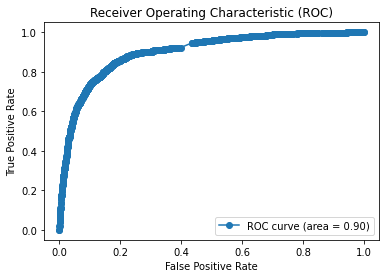

In [81]:
#Predict probabilities
y_pred_prob = bi_lstm_tf_model.predict(X_test_padded).flatten()

#Compute AUC-ROC
auc_roc = roc_auc_score(y_test.values, y_pred_prob)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, marker='o', label='ROC curve (area = %0.2f)' % auc_roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Confusion Matrix:
[[2364  561]
 [ 394 2262]]


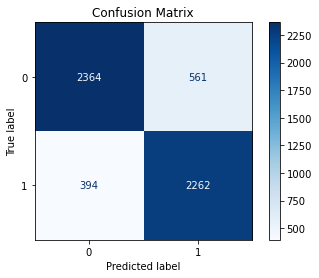

In [82]:
#Predict class labels for confusion matrix
y_pred = bi_lstm_tf_model.predict(X_test_padded).flatten()
y_pred_binary = (y_pred > 0.45).astype(int)

#Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

#Display confusion matrix
print('Confusion Matrix:')
print(cm)

#Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [84]:
#Save the model

bi_lstm_tf_model.save('tri282_bi_lstm_tf_model_sentiment_classification.keras')

# Part VI: Multilabel Classification with Bert

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**Preprocessing Texts**

In [3]:
#View the dataset separated from before
df = pd.read_csv('lol_report_chat.csv')

df.head(3)

,Unnamed: 0,message,association_to_offender,time,case_total_reports,allied_report_count,enemy_report_count,most_common_report_reason,chatlog_id,champion_name
0,0,gold 2 zed,enemy,00:00:21,8,0,2,Negative Attitude,1,Udyr
1,1,IIII,enemy,00:00:27,8,0,2,Negative Attitude,1,Riven
2,2,nice premade lie :o,enemy,00:00:27,8,0,2,Negative Attitude,1,Udyr


In [4]:
#Create a new column that combines the total of reports
df['total_reports'] = df['allied_report_count'] + df['enemy_report_count']

#Rename columns for comprehensiveness
df.rename(columns = {'most_common_report_reason': 'reason'}, inplace = True)

#Drop unused columns
columns_to_drop = ['Unnamed: 0', 'time', 'champion_name', 'association_to_offender', 'case_total_reports', 'allied_report_count', 'enemy_report_count', 'chatlog_id']
df_cleaned = df.drop(columns = columns_to_drop)

df_cleaned.head(3)

,message,reason,total_reports
0,gold 2 zed,Negative Attitude,2
1,IIII,Negative Attitude,2
2,nice premade lie :o,Negative Attitude,2


In [5]:
#The number of labels to be classified
df_cleaned['reason'].unique()

array(['Negative Attitude', 'Offensive Language', 'Assisting Enemy Team',
       'Verbal Abuse', 'Spamming', 'Inappropriate Name'], dtype=object)

In [6]:
#Drop null or empty strings
df_cleaned = df_cleaned[df_cleaned['message'].notna() & (df_cleaned['message'].str.strip() != '')]

df_cleaned.isnull().any()

message          False
reason           False
total_reports    False
dtype: bool

In [18]:
#Clean the texts
df_cleaned['message_cleaned'] = df_cleaned['message'].apply(clean).str.lower()

In [19]:
df_cleaned['message_tokenized'] = df_cleaned['message_cleaned'].apply(gensim_tokenize)

In [20]:
#Initialize the LabelEncoder
label_encoder = LabelEncoder()

#Fit and transform the column
#Transform the 6 categorical variable to numerical values from 0-5
df_cleaned['encoded_label'] = label_encoder.fit_transform(df_cleaned['reason'])

In [21]:
#POS-Tagging on tokenized text
#It is experimented that lemmatization/stemming works slightly (if not much) better with POS-Tagging
df_cleaned['postag_wnet'] = df_cleaned['message_tokenized'].apply(lambda x: pos_tag_wordnet(x))

In [22]:
#Lemmatize text on the POS-Tagged data
df_cleaned['message_lemmatized_w_pos'] = df_cleaned['postag_wnet'].apply(lambda x: nltk_lemmatize(x))

#Remove tokenization since it is better to use ALBert tokenizer instead
df_cleaned['message_lemmatized'] = [' '.join(map(str, l)) for l in df_cleaned['message_lemmatized_w_pos']]

In [23]:
df_cleaned.head(3)

,message,reason,total_reports,message_cleaned,message_tokenized,encoded_label,postag_wnet,message_lemmatized_w_pos,message_lemmatized
0,gold 2 zed,Negative Attitude,2,gold 2 zed,"[gold, zed]",2,"[(gold, a), (zed, n)]","[gold, zed]",gold zed
1,IIII,Negative Attitude,2,iiii,[iiii],2,"[(iiii, n)]",[iiii],iiii
2,nice premade lie :o,Negative Attitude,2,nice premade lie o,"[nice, premade, lie]",2,"[(nice, a), (premade, n), (lie, n)]","[nice, premade, lie]",nice premade lie


In [24]:
#Rename for clarification sake
X = df_cleaned['message_lemmatized']
y = df_cleaned['encoded_label']

#Split the data into training and temporary sets (e.g., 70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 2802)

#Split the temporary set into validation and test sets (e.g., 50% validation, 50% test of the 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 2802)

In [25]:
#Declare the model and tokenizer
model_name = "albert-base-v2"
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels= 6)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#Tokenize, pad, and truncate texts
encodings_train = tokenizer(X_train.tolist(), truncation = True, padding = True, return_tensors = 'pt')
encodings_test = tokenizer(X_test.tolist(), truncation = True, padding = True, return_tensors = 'pt')
encodings_val = tokenizer(X_val.tolist(), truncation = True, padding = True, return_tensors = 'pt')

In [27]:
#Extract tokenized inputs

input_ids_train = encodings_train['input_ids']
input_ids_test = encodings_test['input_ids']
input_ids_val = encodings_val['input_ids']

attention_mask_train = encodings_train['attention_mask']
attention_mask_test = encodings_test['attention_mask']
attention_mask_val = encodings_val['attention_mask']

In [28]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        #Use clone().detach() rather than torch.tensor to avoid copying the data
        self.input_ids = input_ids.clone().detach()
        self.attention_mask = attention_mask.clone().detach()
        
        #Use as_tensor to avoid copying data
        self.labels = torch.as_tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [29]:
#Convert data into the new dataset type
dataset_train = CustomDataset(input_ids_train, attention_mask_train, y_train)
dataset_test = CustomDataset(input_ids_test, attention_mask_test, y_test)
dataset_val = CustomDataset(input_ids_val, attention_mask_val, y_val)

In [30]:
#Load data onto the data loader
dataloader_train = DataLoader(dataset_train, batch_size = 128)
dataloader_test = DataLoader(dataset_test, batch_size = 128)
dataloader_val = DataLoader(dataset_val, batch_size = 128)

In [31]:
class albert_model(nn.Module):
    def __init__(self, num_labels):
        super(albert_model, self).__init__()
        self.bert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels = num_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        #The return values are already a logits of the outputs
        logits = outputs.logits
        
        return logits

In [32]:
def train_model(model, dataloader, criterion, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        #Mount data onto device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        #Zero the gradients for each iteration
        optimizer.zero_grad()
        
        #Forward pass
        outputs = model(input_ids, attention_mask = attention_mask)
        
        #The returned data is already logits, no need to set outputs.logits
        logits = outputs
        
        #Apply softmax to get probabilities
        probabilities = F.softmax(logits, dim = -1)
        
        #Compute loss using logits
        loss = criterion(logits, labels)
        
        #Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    
    return total_loss / len(dataloader)


In [ ]:
#Declare the hyperparams
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = albert_model(num_labels = 6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-4)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 2e-4, max_lr = 0.1, gamma = 0.9, verbose=True)
    
    #Main training loop
    num_epochs = 5
    
    for epoch in range(num_epochs):
        epoch_loss = train_model(model, dataloader_train, criterion, optimizer, device, scheduler)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
